In [81]:
import numpy as np 
import pandas as pd


In [82]:
import warnings
warnings.filterwarnings("ignore")

In [83]:

import os
base_folder_path = "/kaggle/input/eye-diseases-classification/dataset"
folders = os.listdir(base_folder_path)
images_paths = []
labels = []
for fold in folders:
    folder_path = os.path.join(base_folder_path, fold)
    file_paths = os.listdir(folder_path)
    for path in file_paths:
        image_path = os.path.join(folder_path, path)
        images_paths.append(image_path)
        labels.append(fold)
df = pd.DataFrame(data = {"Image Path":images_paths,"Label":labels})
df.head()

,Image Path,Label
0,/kaggle/input/eye-diseases-classification/data...,glaucoma
1,/kaggle/input/eye-diseases-classification/data...,glaucoma
2,/kaggle/input/eye-diseases-classification/data...,glaucoma
3,/kaggle/input/eye-diseases-classification/data...,glaucoma
4,/kaggle/input/eye-diseases-classification/data...,glaucoma


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Path  4217 non-null   object
 1   Label       4217 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


# Data split

In [85]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [87]:
train_df , test_df = train_test_split(df,test_size=0.2,random_state=42,stratify=df["Label"])
test_df,valid_df = train_test_split(test_df,test_size=0.5,random_state=42,stratify=test_df["Label"])

In [88]:
print("Train Shape : ",train_df.shape)
print("Test Shape : ",test_df.shape)
print("Validation Shape ",valid_df.shape)

Train Shape :  (3373, 2)
Test Shape :  (422, 2)
Validation Shape  (422, 2)


In [89]:
print("Train Classes : ",train_df.Label.value_counts())
print("Test Classes : ",test_df.Label.value_counts())
print("Validation Classes",valid_df.Label.value_counts())

Train Classes :  Label
diabetic_retinopathy    878
normal                  859
cataract                830
glaucoma                806
Name: count, dtype: int64
Test Classes :  Label
diabetic_retinopathy    110
normal                  108
cataract                104
glaucoma                100
Name: count, dtype: int64
Validation Classes Label
diabetic_retinopathy    110
normal                  107
cataract                104
glaucoma                101
Name: count, dtype: int64


# Data Augmentation

In [90]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt

In [91]:
datagen_train = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,  
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    rescale=1./255 
)

In [92]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col="Label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=valid_df,
    x_col="Image Path",
    y_col="Label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col="Label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


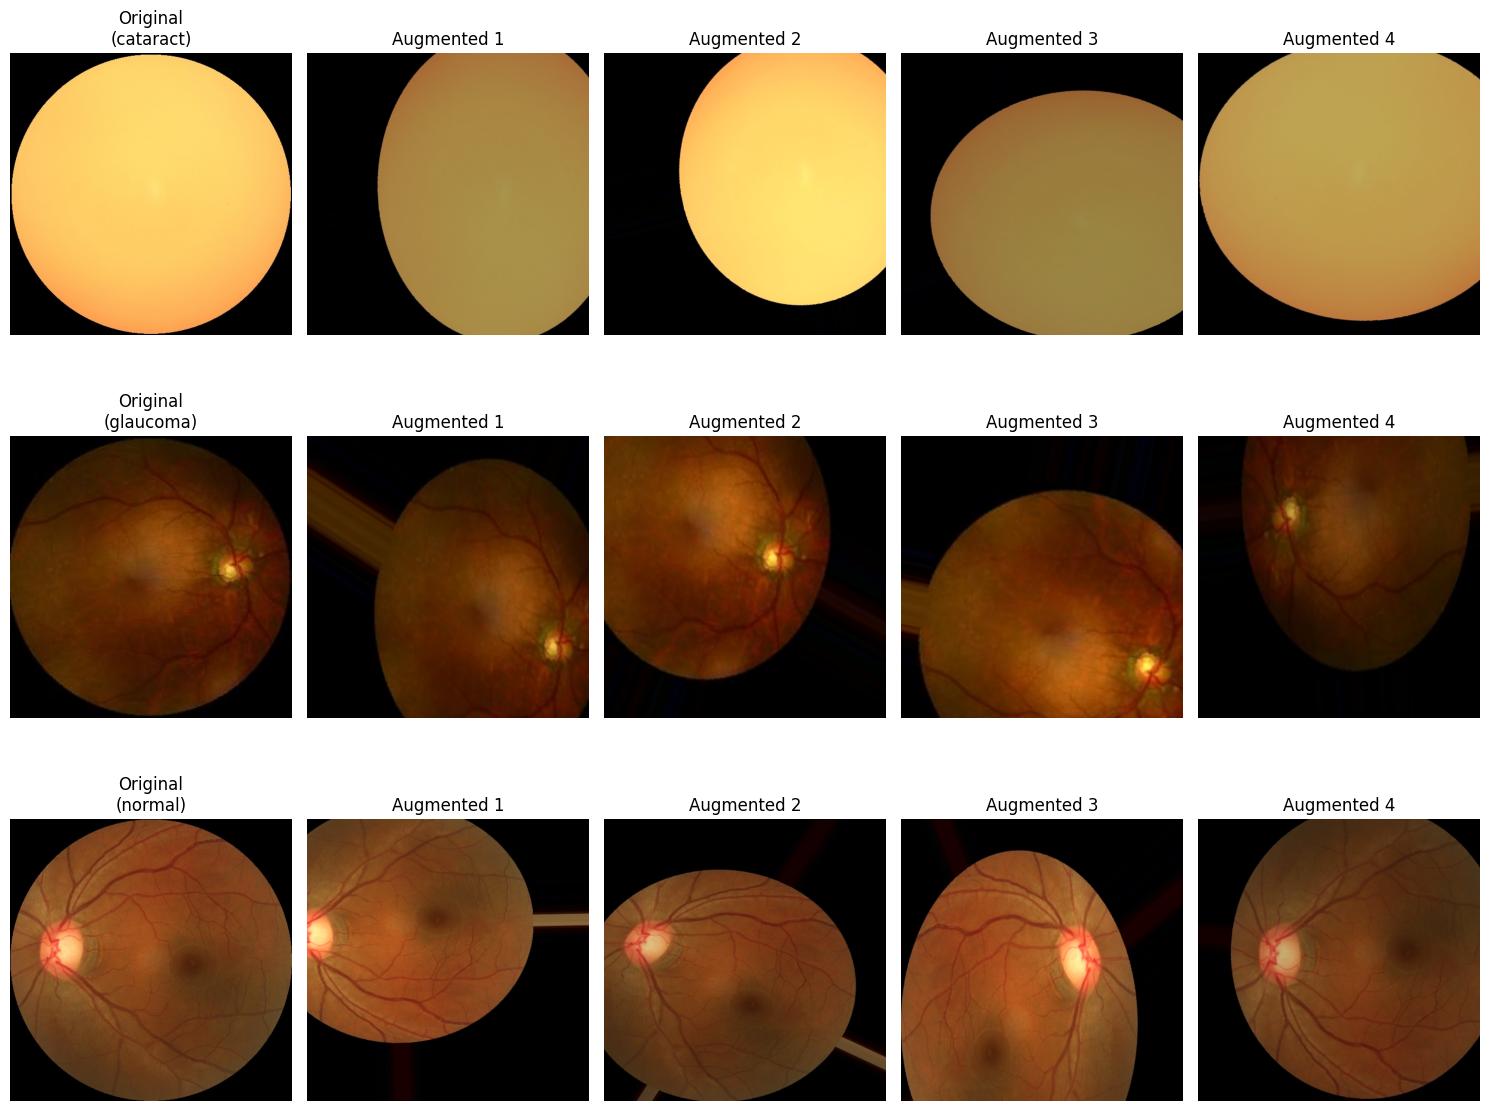

In [93]:
sample_paths = train_df['Image Path'].sample(3).tolist()
n_samples = len(sample_paths)
n_augmentations = 4  

plt.figure(figsize=(15, 4 * n_samples))

for i, img_path in enumerate(sample_paths):
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    plt.subplot(n_samples, n_augmentations + 1, i * (n_augmentations + 1) + 1)
    plt.imshow(img)
    plt.title(f"Original\n({train_df[train_df['Image Path'] == img_path]['Label'].iloc[0]})")
    plt.axis('off')

    # --- Plot Augmented Images ---
    i_aug = 0
    for batch in datagen_train.flow(x, batch_size=1):
        augmented_img = (batch[0] * 255).astype('uint8') 
        
        plt.subplot(n_samples, n_augmentations + 1, i * (n_augmentations + 1) + 2 + i_aug)
        plt.imshow(augmented_img)
        plt.title(f"Augmented {i_aug + 1}")
        plt.axis('off')
        
        i_aug += 1
        if i_aug >= n_augmentations:
            break 

plt.tight_layout()
plt.show()


# Build CNN

In [94]:
import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense ,BatchNormalization ,GlobalAveragePooling2D,Dropout,Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [95]:

cnn_model = Sequential()


cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))  

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 10, 10, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,068 (1.98 MB)

 Trainable params: 520,068 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
history = cnn_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=70
)


Epoch 1/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 578ms/step - accuracy: 0.2866 - loss: 1.3721 - val_accuracy: 0.3389 - val_loss: 1.2897
Epoch 2/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 566ms/step - accuracy: 0.3979 - loss: 1.2593 - val_accuracy: 0.4100 - val_loss: 1.1945
Epoch 3/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 564ms/step - accuracy: 0.4368 - loss: 1.1944 - val_accuracy: 0.5000 - val_loss: 1.0765
Epoch 4/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 563ms/step - accuracy: 0.4902 - loss: 1.1059 - val_accuracy: 0.5024 - val_loss: 1.0614
Epoch 5/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 565ms/step - accuracy: 0.5360 - loss: 1.0262 - val_accuracy: 0.5972 - val_loss: 0.9134
Epoch 6/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 567ms/step - accuracy: 0.5438 - loss: 1.0036 - val_accuracy: 0.6066 - val_loss: 0.9161
Epoch 7/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 562ms/step - accuracy: 0.5800 - loss: 0.9786 - val_accuracy: 0.5806 - val_loss: 0.9279
Epoch 8/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 563ms/step - accuracy: 0.5914 - loss: 0

In [99]:
history = cnn_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5
)


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 578ms/step - accuracy: 0.8370 - loss: 0.4318 - val_accuracy: 0.7488 - val_loss: 0.6180
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 572ms/step - accuracy: 0.8249 - loss: 0.4334 - val_accuracy: 0.7701 - val_loss: 0.5548
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 572ms/step - accuracy: 0.8357 - loss: 0.4321 - val_accuracy: 0.7512 - val_loss: 0.7074
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 571ms/step - accuracy: 0.8298 - loss: 0.4449 - val_accuracy: 0.7938 - val_loss: 0.5146
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 570ms/step - accuracy: 0.8395 - loss: 0.4282 - val_accuracy: 0.7891 - val_loss: 0.5067


In [104]:
history = cnn_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5
)


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 575ms/step - accuracy: 0.8417 - loss: 0.4069 - val_accuracy: 0.7701 - val_loss: 0.5620
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 568ms/step - accuracy: 0.8313 - loss: 0.4403 - val_accuracy: 0.8009 - val_loss: 0.4614
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 567ms/step - accuracy: 0.8177 - loss: 0.4532 - val_accuracy: 0.7796 - val_loss: 0.5583
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 569ms/step - accuracy: 0.8394 - loss: 0.4137 - val_accuracy: 0.7725 - val_loss: 0.5817
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 568ms/step - accuracy: 0.8358 - loss: 0.4241 - val_accuracy: 0.8009 - val_loss: 0.4917


In [105]:
test_loss, test_acc = cnn_model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.8054 - loss: 0.4724
Test Accuracy: 0.8199052214622498


In [106]:
valid_gen.reset()
y_pred = cnn_model.predict(valid_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1:", f1_score(y_true, y_pred, average='weighted'))


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step
Precision: 0.8379271789109911
Recall: 0.8009478672985783
F1: 0.804699769288285


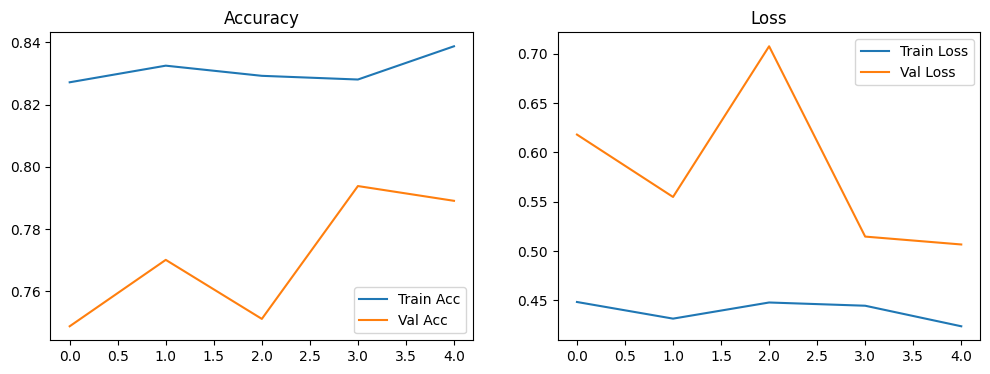

In [101]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


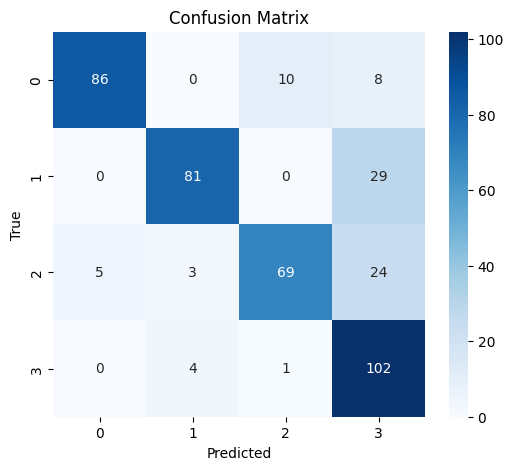

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
